<a href="https://colab.research.google.com/github/whoawoo/api_class/blob/main/VAE_CLASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


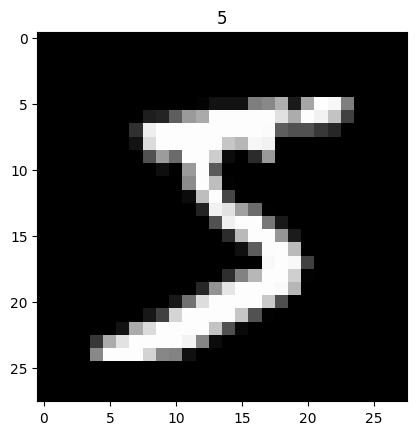

훈련용 데이터의 형태:  (60000, 784) 테스트용 데이터의 형태:  (10000, 784)


In [7]:
x_train = x_train/255
x_test = x_test/255

plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title(t_train[0])
plt.show()

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print("훈련용 데이터의 형태: ", x_train.shape, "테스트용 데이터의 형태: ", x_test.shape)

In [10]:
epochs = 10
batch_size = 128
n_in_out = 784
n_z = 2
n_mid = 256

In [9]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import metrics
from tensorflow.python.keras.layers import Input, Dense, Lambda
from tensorflow.python.keras  import backend as K

In [11]:
def z_sample(args):
  mu, log_var = args
  epsilon = K.random_normal(shape=K.shape(log_var), mean = 0, stddev=1)
  return mu + epsilon * K.exp(log_var / 2)

In [12]:
x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)
mu = Dense(n_z)(h_encoder)
log_var = Dense(n_z)(h_encoder)
z = Lambda(z_sample, output_shape=(n_z,))([mu, log_var])

In [13]:
mid_decoder = Dense(n_mid, activation="relu")
h_decoder = mid_decoder(z)
out_decoder = Dense(n_in_out, activation="sigmoid")
y = out_decoder(h_decoder)

In [14]:
model_vae = Model(x, y)

eps = 1e-7
rec_loss = K.sum(-x*K.log(y + eps) - (1 - x)*K.log(1 - y +eps)) / batch_size

In [15]:
reg_loss = - 0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var)) / batch_size
vae_loss = rec_loss + reg_loss

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="adam")
model_vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            514         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense[0][0]                      
______________________________________________________________________________________________

In [16]:
model_vae.fit(x_train, x_train,
              shuffle=True,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 5s 3ms/step - loss: 203.0937 - val_loss: 173.3619
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 171.4810 - val_loss: 166.6040
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 166.8293 - val_loss: 164.0783
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 164.5440 - val_loss: 162.1035
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 162.9217 - val_loss: 160.9561
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 161.6047 - val_loss: 159.8211
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 160.3501 - val_loss: 158.5670
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 159.2948 - val_loss: 157.6642
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 158.3036 - val_loss: 156.7874
Epoch 10/10
469/469 [==============================] - 2s 4ms/st

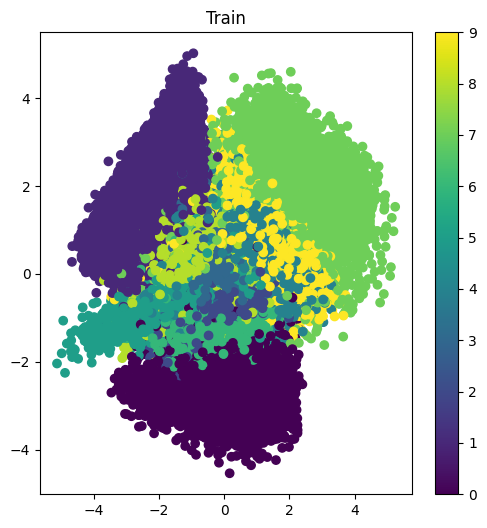

In [18]:
encoder = Model(x, z)


z_train = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_train[:, 0], z_train[:, 1], c=t_train)
plt.title("Train")
plt.colorbar()
plt.show()

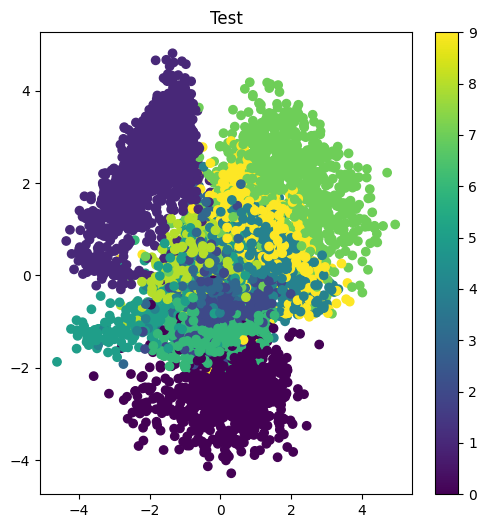

In [19]:
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=t_test)
plt.title("Test")
plt.colorbar()
plt.show()

In [20]:
input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder(input_decoder)
y = out_decoder(h_decoder)
generator = Model(input_decoder, y)

In [21]:
n = 16
image_size = 28
matrix_image = np.zeros((image_size*n, image_size*n))

z_1 = np.linspace(2, -2, n)
z_2 = np.linspace(-2, 2, n)

In [22]:
for i, z1 in enumerate(z_1):
  for j, z2 in enumerate(z_2):
    decoded = generator.predict(np.array([[z2, z1]]))
    image = decoded[0].reshape(image_size, image_size)
    matrix_image[i*image_size : (i+1)*image_size, j*image_size: (j+1)*image_size] = image

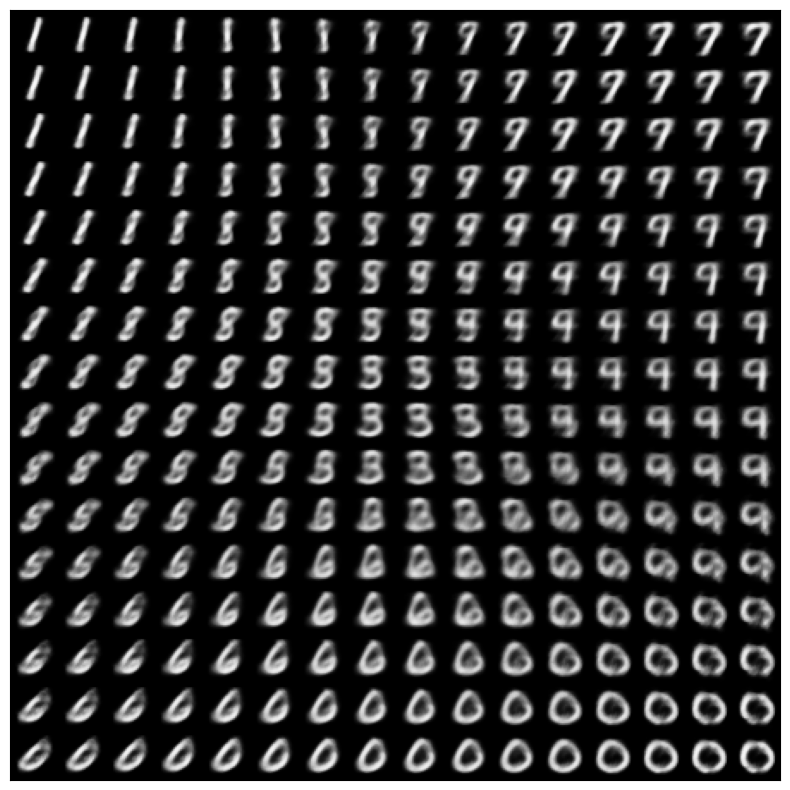

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(matrix_image, cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()